In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 55)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 55, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer')(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 10800)        0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 4/10 [===========>..................] - ETA: 0s - loss: 0.1726 - rmse: 0.4153 
Epoch 1: val_loss improved from inf to 0.16206, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 4s 57ms/step - loss: 0.1763 - rmse: 0.4197 - val_loss: 0.1621 - val_rmse: 0.4024 - lr: 1.0000e-04
Epoch 2/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1276 - rmse: 0.3570
Epoch 2: val_loss improved from 0.16206 to 0.09188, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.1250 - rmse: 0.3533 - val_loss: 0.0919 - val_rmse: 0.3029 - lr: 1.0000e-04
Epoch 3/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0719 - rmse: 0.2679
Epoch 3: val_loss improved from 

Epoch 21/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0578 - rmse: 0.2400
Epoch 21: val_loss did not improve from 0.06232
10/10 [==============================] - 0s 13ms/step - loss: 0.0593 - rmse: 0.2431 - val_loss: 0.0627 - val_rmse: 0.2502 - lr: 1.0000e-04
Epoch 22/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0560 - rmse: 0.2362
Epoch 22: val_loss improved from 0.06232 to 0.06215, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0554 - rmse: 0.2351 - val_loss: 0.0621 - val_rmse: 0.2490 - lr: 1.0000e-04
Epoch 23/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0553 - rmse: 0.2349
Epoch 23: val_loss improved from 0.06215 to 0.06214, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers

Epoch 42/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0515 - rmse: 0.2266
Epoch 42: val_loss improved from 0.05751 to 0.05744, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0515 - rmse: 0.2267 - val_loss: 0.0574 - val_rmse: 0.2394 - lr: 1.0000e-04
Epoch 43/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0524 - rmse: 0.2286
Epoch 43: val_loss did not improve from 0.05744
10/10 [==============================] - 0s 13ms/step - loss: 0.0512 - rmse: 0.2259 - val_loss: 0.0579 - val_rmse: 0.2404 - lr: 1.0000e-04
Epoch 44/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0519 - rmse: 0.2275
Epoch 44: val_loss improved from 0.05744 to 0.05661, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers

10/10 [==============================] - 0s 28ms/step - loss: 0.0292 - rmse: 0.1703 - val_loss: 0.0310 - val_rmse: 0.1755 - lr: 1.0000e-04
Epoch 62/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0323 - rmse: 0.1793
Epoch 62: val_loss improved from 0.03096 to 0.02565, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0297 - rmse: 0.1718 - val_loss: 0.0256 - val_rmse: 0.1597 - lr: 1.0000e-04
Epoch 63/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0235 - rmse: 0.1529
Epoch 63: val_loss improved from 0.02565 to 0.02143, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0230 - rmse: 0.1513 - val_loss: 0.0214 - val_rmse: 0.1

10/10 [==============================] - 0s 31ms/step - loss: 0.0020 - rmse: 0.0427 - val_loss: 0.0022 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 81/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0017 - rmse: 0.0390
Epoch 81: val_loss improved from 0.00217 to 0.00205, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0017 - rmse: 0.0395 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 82/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0018 - rmse: 0.0403
Epoch 82: val_loss improved from 0.00205 to 0.00192, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0019 - val_rmse: 0.0

Epoch 102/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0306    
Epoch 102: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0295 - val_loss: 0.0011 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 103/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6266e-04 - rmse: 0.0268
Epoch 103: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 14ms/step - loss: 8.8959e-04 - rmse: 0.0273 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 104/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0302
Epoch 104: val_loss improved from 0.00105 to 0.00096, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0010 - rmse: 0.0295 - val_loss: 9.6128e-04 - val_rmse:

Epoch 125/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5362e-04 - rmse: 0.0203
Epoch 125: val_loss improved from 0.00063 to 0.00062, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 34ms/step - loss: 5.6920e-04 - rmse: 0.0207 - val_loss: 6.2353e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.3901e-04 - rmse: 0.0223
Epoch 126: val_loss did not improve from 0.00062
10/10 [==============================] - 0s 14ms/step - loss: 6.3667e-04 - rmse: 0.0223 - val_loss: 6.6620e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 127/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.5736e-04 - rmse: 0.0204
Epoch 127: val_loss improved from 0.00062 to 0.00058, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_va

Epoch 148/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7054e-04 - rmse: 0.0208
Epoch 148: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 12ms/step - loss: 5.4274e-04 - rmse: 0.0201 - val_loss: 5.4339e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 149/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7344e-04 - rmse: 0.0209
Epoch 149: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 12ms/step - loss: 5.8896e-04 - rmse: 0.0212 - val_loss: 5.0655e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 150/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.2455e-04 - rmse: 0.0221
Epoch 150: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 12ms/step - loss: 6.2813e-04 - rmse: 0.0221 - val_loss: 8.6121e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 151/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.6424e-04 - rmse: 0.0229
Epoch 151: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 4.7082e-04 - rmse: 0.0183
Epoch 174: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 12ms/step - loss: 4.6515e-04 - rmse: 0.0182 - val_loss: 5.2689e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 175/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1574e-04 - rmse: 0.0168
Epoch 175: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 12ms/step - loss: 4.2816e-04 - rmse: 0.0171 - val_loss: 4.8752e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 176/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5887e-04 - rmse: 0.0180
Epoch 176: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 12ms/step - loss: 4.5574e-04 - rmse: 0.0179 - val_loss: 5.4909e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 177/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5413e-04 - rmse: 0.0179
Epoch 177: val_loss improved fro

10/10 [==============================] - 0s 27ms/step - loss: 3.7620e-04 - rmse: 0.0156 - val_loss: 3.8091e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 201/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8846e-04 - rmse: 0.0160
Epoch 201: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 12ms/step - loss: 3.8953e-04 - rmse: 0.0161 - val_loss: 4.2120e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 202/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9232e-04 - rmse: 0.0162
Epoch 202: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 13ms/step - loss: 4.1161e-04 - rmse: 0.0168 - val_loss: 3.9814e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 203/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8042e-04 - rmse: 0.0187
Epoch 203: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 15ms/step - loss: 4.5112e-04 - rmse: 0.0179 - val_loss: 4.4165e-04 - va

 8/10 [=======================>......] - ETA: 0s - loss: 3.7176e-04 - rmse: 0.0156
Epoch 228: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 12ms/step - loss: 3.7686e-04 - rmse: 0.0158 - val_loss: 4.2245e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 229/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8678e-04 - rmse: 0.0161
Epoch 229: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 12ms/step - loss: 3.7028e-04 - rmse: 0.0156 - val_loss: 3.8576e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 230/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8131e-04 - rmse: 0.0159
Epoch 230: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 12ms/step - loss: 3.8458e-04 - rmse: 0.0160 - val_loss: 4.0076e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 231/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7593e-04 - rmse: 0.0158
Epoch 231: val_loss improved fro

Epoch 254/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4444e-04 - rmse: 0.0179
Epoch 254: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 4.4084e-04 - rmse: 0.0178 - val_loss: 4.3744e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 255/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1073e-04 - rmse: 0.0169
Epoch 255: val_loss improved from 0.00037 to 0.00035, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 4.1378e-04 - rmse: 0.0170 - val_loss: 3.5236e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 256/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6721e-04 - rmse: 0.0156
Epoch 256: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.8938e-04 - rmse: 0.0163 - val_loss: 3.

 7/10 [====================>.........] - ETA: 0s - loss: 4.4974e-04 - rmse: 0.0181
Epoch 281: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.8021e-04 - rmse: 0.0190 - val_loss: 6.6810e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 282/10000
 7/10 [====================>.........] - ETA: 0s - loss: 6.8613e-04 - rmse: 0.0238
Epoch 282: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 6.4198e-04 - rmse: 0.0228 - val_loss: 5.1788e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 283/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.8756e-04 - rmse: 0.0192
Epoch 283: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.6307e-04 - rmse: 0.0185 - val_loss: 4.5167e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 284/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.1270e-04 - rmse: 0.0171
Epoch 284: val_loss did not impr

Epoch 309/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.5504e-04 - rmse: 0.0184
Epoch 309: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 13ms/step - loss: 4.4819e-04 - rmse: 0.0182 - val_loss: 3.8162e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 310/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6983e-04 - rmse: 0.0159
Epoch 310: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 13ms/step - loss: 3.5283e-04 - rmse: 0.0153 - val_loss: 3.5811e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 311/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7149e-04 - rmse: 0.0159
Epoch 311: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.6307e-04 - rmse: 0.0157 - val_loss: 3.9555e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 312/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5571e-04 - rmse: 0.0154
Epoch 312: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.8106e-04 - rmse: 0.0163
Epoch 336: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.8181e-04 - rmse: 0.0164 - val_loss: 3.8409e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 337/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4933e-04 - rmse: 0.0153
Epoch 337: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.5762e-04 - rmse: 0.0156 - val_loss: 3.5096e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 338/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4449e-04 - rmse: 0.0152
Epoch 338: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 12ms/step - loss: 3.3452e-04 - rmse: 0.0148 - val_loss: 3.8455e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 339/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.0371e-04 - rmse: 0.0170
Epoch 339: val_loss did not impr

Epoch 364/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6454e-04 - rmse: 0.0188
Epoch 364: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 15ms/step - loss: 4.4610e-04 - rmse: 0.0183 - val_loss: 3.9269e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 365/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3070e-04 - rmse: 0.0179
Epoch 365: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 15ms/step - loss: 4.2967e-04 - rmse: 0.0178 - val_loss: 5.0313e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 366/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6099e-04 - rmse: 0.0187
Epoch 366: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 14ms/step - loss: 4.8162e-04 - rmse: 0.0192 - val_loss: 4.4581e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 367/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.3020e-04 - rmse: 0.0205
Epoch 367: val_l

Epoch 392/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7003e-04 - rmse: 0.0162
Epoch 392: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 13ms/step - loss: 3.7404e-04 - rmse: 0.0163 - val_loss: 3.4857e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 393/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3758e-04 - rmse: 0.0151
Epoch 393: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 14ms/step - loss: 3.5678e-04 - rmse: 0.0158 - val_loss: 4.1177e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 394/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4398e-04 - rmse: 0.0183
Epoch 394: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 13ms/step - loss: 4.5737e-04 - rmse: 0.0187 - val_loss: 3.8478e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 395/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2577e-04 - rmse: 0.0178
Epoch 395: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.7430e-04 - rmse: 0.0164
Epoch 419: val_loss improved from 0.00033 to 0.00032, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 3.6681e-04 - rmse: 0.0162 - val_loss: 3.1952e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 420/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5106e-04 - rmse: 0.0157
Epoch 420: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 13ms/step - loss: 3.6233e-04 - rmse: 0.0160 - val_loss: 3.9489e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 421/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6041e-04 - rmse: 0.0160
Epoch 421: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 13ms/step - loss: 3.8472e-04 - rmse: 0.0167 - val_loss: 3.5471e-04 - val_r

 7/10 [====================>.........] - ETA: 0s - loss: 3.9522e-04 - rmse: 0.0171
Epoch 446: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.1145e-04 - rmse: 0.0176 - val_loss: 4.1556e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 447/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9501e-04 - rmse: 0.0171
Epoch 447: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.9483e-04 - rmse: 0.0171 - val_loss: 4.2634e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 448/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9967e-04 - rmse: 0.0172
Epoch 448: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 13ms/step - loss: 4.1026e-04 - rmse: 0.0175 - val_loss: 4.4112e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 449/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4071e-04 - rmse: 0.0154
Epoch 449: val_loss did not impr

Epoch 474/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.2410e-04 - rmse: 0.0206
Epoch 474: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.9925e-04 - rmse: 0.0200 - val_loss: 4.1326e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 475/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7421e-04 - rmse: 0.0165
Epoch 475: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.7376e-04 - rmse: 0.0165 - val_loss: 3.6751e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 476/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6113e-04 - rmse: 0.0190
Epoch 476: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 4.5072e-04 - rmse: 0.0187 - val_loss: 3.9499e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 477/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7092e-04 - rmse: 0.0164
Epoch 477: val_l

Epoch 502/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7232e-04 - rmse: 0.0165
Epoch 502: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.6145e-04 - rmse: 0.0162 - val_loss: 3.6881e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 503/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9361e-04 - rmse: 0.0172
Epoch 503: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.8750e-04 - rmse: 0.0170 - val_loss: 3.8280e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 504/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7413e-04 - rmse: 0.0166
Epoch 504: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.7354e-04 - rmse: 0.0166 - val_loss: 4.4615e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 505/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5244e-04 - rmse: 0.0159
Epoch 505: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.3419e-04 - rmse: 0.0154
Epoch 529: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4361e-04 - rmse: 0.0157 - val_loss: 4.2254e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 530/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6909e-04 - rmse: 0.0165
Epoch 530: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6567e-04 - rmse: 0.0164 - val_loss: 4.3006e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 531/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5753e-04 - rmse: 0.0162
Epoch 531: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.5282e-04 - rmse: 0.0160 - val_loss: 4.2436e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 532/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.2870e-04 - rmse: 0.0182
Epoch 532: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 3.7558e-04 - rmse: 0.0168
Epoch 556: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6405e-04 - rmse: 0.0164 - val_loss: 3.8506e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 557/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4223e-04 - rmse: 0.0157
Epoch 557: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4048e-04 - rmse: 0.0157 - val_loss: 3.6071e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 558/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3933e-04 - rmse: 0.0157
Epoch 558: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4038e-04 - rmse: 0.0157 - val_loss: 3.2669e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 559/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5395e-04 - rmse: 0.0161
Epoch 559: val_loss did not impr

Epoch 584/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9796e-04 - rmse: 0.0143
Epoch 584: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1803e-04 - rmse: 0.0150 - val_loss: 3.2482e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 585/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4357e-04 - rmse: 0.0159
Epoch 585: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.4354e-04 - rmse: 0.0159 - val_loss: 3.7397e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 586/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7272e-04 - rmse: 0.0167
Epoch 586: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.6344e-04 - rmse: 0.0165 - val_loss: 3.3760e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 587/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1836e-04 - rmse: 0.0150
Epoch 587: val_l

Epoch 612/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0047e-04 - rmse: 0.0145
Epoch 612: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8806e-04 - rmse: 0.0141 - val_loss: 3.2191e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 613/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7923e-04 - rmse: 0.0170
Epoch 613: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.7919e-04 - rmse: 0.0170 - val_loss: 3.0763e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 614/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9845e-04 - rmse: 0.0144
Epoch 614: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.2323e-04 - rmse: 0.0153 - val_loss: 3.6710e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 615/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5260e-04 - rmse: 0.0162
Epoch 615: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 2.9438e-04 - rmse: 0.0143
Epoch 639: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0016e-04 - rmse: 0.0145 - val_loss: 3.2470e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 640/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9926e-04 - rmse: 0.0145
Epoch 640: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1287e-04 - rmse: 0.0150 - val_loss: 3.4925e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 641/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9039e-04 - rmse: 0.0142
Epoch 641: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9754e-04 - rmse: 0.0145 - val_loss: 3.2837e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 642/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0686e-04 - rmse: 0.0148
Epoch 642: val_loss did not impr

Epoch 667/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2349e-04 - rmse: 0.0154
Epoch 667: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1259e-04 - rmse: 0.0150 - val_loss: 3.8322e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 668/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3208e-04 - rmse: 0.0157
Epoch 668: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.3959e-04 - rmse: 0.0159 - val_loss: 4.4401e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 669/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8664e-04 - rmse: 0.0173
Epoch 669: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.7090e-04 - rmse: 0.0169 - val_loss: 3.7013e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 670/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2278e-04 - rmse: 0.0154
Epoch 670: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 3.8809e-04 - rmse: 0.0174
Epoch 693: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.9544e-04 - rmse: 0.0176 - val_loss: 3.4189e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 694/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2890e-04 - rmse: 0.0156
Epoch 694: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.2238e-04 - rmse: 0.0154 - val_loss: 3.5892e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 695/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4242e-04 - rmse: 0.0160
Epoch 695: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.4041e-04 - rmse: 0.0160 - val_loss: 3.5329e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 696/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3237e-04 - rmse: 0.0157
Epoch 696: val_loss did not impr

Epoch 721/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2477e-04 - rmse: 0.0155
Epoch 721: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.2696e-04 - rmse: 0.0156 - val_loss: 3.5334e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 722/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5730e-04 - rmse: 0.0165
Epoch 722: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.4217e-04 - rmse: 0.0161 - val_loss: 3.5370e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 723/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3367e-04 - rmse: 0.0158
Epoch 723: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.2554e-04 - rmse: 0.0156 - val_loss: 3.2869e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 724/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4957e-04 - rmse: 0.0163
Epoch 724: val_l

Epoch 749/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4539e-04 - rmse: 0.0191
Epoch 749: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.2012e-04 - rmse: 0.0184 - val_loss: 3.5104e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 750/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2850e-04 - rmse: 0.0157
Epoch 750: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.4510e-04 - rmse: 0.0162 - val_loss: 4.0178e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 751/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6776e-04 - rmse: 0.0196
Epoch 751: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 4.3805e-04 - rmse: 0.0189 - val_loss: 4.4641e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 752/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.4817e-04 - rmse: 0.0191
Epoch 752: val_l

Epoch 777/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6482e-04 - rmse: 0.0136
Epoch 777: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.7919e-04 - rmse: 0.0141 - val_loss: 3.6668e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 778/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8557e-04 - rmse: 0.0143
Epoch 778: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8760e-04 - rmse: 0.0144 - val_loss: 2.9674e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 779/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9110e-04 - rmse: 0.0145
Epoch 779: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.0542e-04 - rmse: 0.0150 - val_loss: 3.4378e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 780/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.5831e-04 - rmse: 0.0167
Epoch 780: val_l

Epoch 805/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8283e-04 - rmse: 0.0143
Epoch 805: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.9189e-04 - rmse: 0.0146 - val_loss: 3.0073e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 806/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.8524e-04 - rmse: 0.0175
Epoch 806: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.7786e-04 - rmse: 0.0173 - val_loss: 3.7794e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 807/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.9304e-04 - rmse: 0.0177
Epoch 807: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.7201e-04 - rmse: 0.0171 - val_loss: 3.3887e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 808/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9854e-04 - rmse: 0.0179
Epoch 808: val_l

Epoch 833/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0161e-04 - rmse: 0.0150
Epoch 833: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.9802e-04 - rmse: 0.0148 - val_loss: 3.0963e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 834/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8795e-04 - rmse: 0.0145
Epoch 834: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 2.8297e-04 - rmse: 0.0143 - val_loss: 2.9195e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 835/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1156e-04 - rmse: 0.0153
Epoch 835: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 12ms/step - loss: 3.0733e-04 - rmse: 0.0151 - val_loss: 3.4353e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 836/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.4512e-04 - rmse: 0.0163
Epoch 836: val_l

Epoch 860/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2743e-04 - rmse: 0.0158
Epoch 860: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.2536e-04 - rmse: 0.0158 - val_loss: 3.1380e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 861/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2573e-04 - rmse: 0.0158
Epoch 861: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.1721e-04 - rmse: 0.0155 - val_loss: 3.2200e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 862/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3796e-04 - rmse: 0.0162
Epoch 862: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.6655e-04 - rmse: 0.0170 - val_loss: 5.4460e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 863/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.6394e-04 - rmse: 0.0197
Epoch 863: val_l

Epoch 888/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3751e-04 - rmse: 0.0162
Epoch 888: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.3915e-04 - rmse: 0.0162 - val_loss: 2.9754e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 889/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8831e-04 - rmse: 0.0146
Epoch 889: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.8298e-04 - rmse: 0.0144 - val_loss: 3.2346e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 890/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0781e-04 - rmse: 0.0152
Epoch 890: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0632e-04 - rmse: 0.0152 - val_loss: 2.8784e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 891/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9242e-04 - rmse: 0.0147
Epoch 891: val_l

Epoch 916/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3763e-04 - rmse: 0.0162
Epoch 916: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.3456e-04 - rmse: 0.0161 - val_loss: 3.8507e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 917/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2037e-04 - rmse: 0.0186
Epoch 917: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 4.2105e-04 - rmse: 0.0186 - val_loss: 5.2782e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 918/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.4956e-04 - rmse: 0.0218
Epoch 918: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 5.3853e-04 - rmse: 0.0215 - val_loss: 7.9209e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 919/10000
 7/10 [====================>.........] - ETA: 0s - loss: 5.7875e-04 - rmse: 0.0225
Epoch 919: val_l

Epoch 944/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8856e-04 - rmse: 0.0147
Epoch 944: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0220e-04 - rmse: 0.0151 - val_loss: 3.1936e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 945/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2260e-04 - rmse: 0.0158
Epoch 945: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.2516e-04 - rmse: 0.0159 - val_loss: 3.1317e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 946/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9993e-04 - rmse: 0.0151
Epoch 946: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.9890e-04 - rmse: 0.0150 - val_loss: 3.2739e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 947/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1561e-04 - rmse: 0.0156
Epoch 947: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 2.8215e-04 - rmse: 0.0145
Epoch 971: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.9990e-04 - rmse: 0.0151 - val_loss: 3.1906e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 972/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0366e-04 - rmse: 0.0152
Epoch 972: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 2.9663e-04 - rmse: 0.0150 - val_loss: 2.9598e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 973/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9483e-04 - rmse: 0.0149
Epoch 973: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 12ms/step - loss: 3.0073e-04 - rmse: 0.0151 - val_loss: 3.7418e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 974/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0998e-04 - rmse: 0.0154
Epoch 974: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 3.4340e-04 - rmse: 0.0165
Epoch 998: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.4262e-04 - rmse: 0.0165 - val_loss: 3.5444e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 999/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2526e-04 - rmse: 0.0159
Epoch 999: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.1722e-04 - rmse: 0.0157 - val_loss: 4.3012e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 1000/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7059e-04 - rmse: 0.0173
Epoch 1000: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.4663e-04 - rmse: 0.0166 - val_loss: 3.4410e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 1001/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3646e-04 - rmse: 0.0163
Epoch 1001: val_loss did not 

Epoch 1026/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.3015e-04 - rmse: 0.0161
Epoch 1026: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.4589e-04 - rmse: 0.0166 - val_loss: 4.0576e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 1027/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8774e-04 - rmse: 0.0178
Epoch 1027: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.8615e-04 - rmse: 0.0178 - val_loss: 3.4725e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1028/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.6094e-04 - rmse: 0.0170
Epoch 1028: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.5989e-04 - rmse: 0.0170 - val_loss: 4.0053e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1029/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.1759e-04 - rmse: 0.0157
Epoch 102

Epoch 1054/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8374e-04 - rmse: 0.0146
Epoch 1054: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.8719e-04 - rmse: 0.0148 - val_loss: 3.4660e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1055/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.2277e-04 - rmse: 0.0159
Epoch 1055: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.2586e-04 - rmse: 0.0160 - val_loss: 3.0220e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1056/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9350e-04 - rmse: 0.0150
Epoch 1056: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.9739e-04 - rmse: 0.0151 - val_loss: 3.0865e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 1057/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0202e-04 - rmse: 0.0153
Epoch 105

Epoch 1082/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8587e-04 - rmse: 0.0147
Epoch 1082: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7951e-04 - rmse: 0.0145 - val_loss: 2.9877e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 1083/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8361e-04 - rmse: 0.0147
Epoch 1083: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7675e-04 - rmse: 0.0144 - val_loss: 3.2054e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1084/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1853e-04 - rmse: 0.0158
Epoch 1084: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.0080e-04 - rmse: 0.0152 - val_loss: 3.0574e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1085/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8196e-04 - rmse: 0.0146
Epoch 108

Epoch 1110/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0683e-04 - rmse: 0.0155
Epoch 1110: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.9877e-04 - rmse: 0.0152 - val_loss: 3.0407e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1111/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8509e-04 - rmse: 0.0147
Epoch 1111: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.8257e-04 - rmse: 0.0147 - val_loss: 3.0163e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1112/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7564e-04 - rmse: 0.0144
Epoch 1112: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.8239e-04 - rmse: 0.0147 - val_loss: 3.1112e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 1113/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0489e-04 - rmse: 0.0154
Epoch 111

 7/10 [====================>.........] - ETA: 0s - loss: 3.1345e-04 - rmse: 0.0157
Epoch 1137: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.2235e-04 - rmse: 0.0160 - val_loss: 3.3594e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 1138/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0742e-04 - rmse: 0.0155
Epoch 1138: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.0617e-04 - rmse: 0.0155 - val_loss: 3.0404e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1139/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1103e-04 - rmse: 0.0156
Epoch 1139: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.0931e-04 - rmse: 0.0156 - val_loss: 3.3710e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 1140/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0335e-04 - rmse: 0.0154
Epoch 1140: val_loss did n

Epoch 1165/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.9705e-04 - rmse: 0.0152
Epoch 1165: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.0099e-04 - rmse: 0.0153 - val_loss: 4.0498e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 1166/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4030e-04 - rmse: 0.0166
Epoch 1166: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.3520e-04 - rmse: 0.0164 - val_loss: 3.1179e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 1167/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0906e-04 - rmse: 0.0156
Epoch 1167: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 3.1022e-04 - rmse: 0.0156 - val_loss: 2.9599e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 1168/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0298e-04 - rmse: 0.0154
Epoch 116

Epoch 1192/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7548e-04 - rmse: 0.0145
Epoch 1192: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.6311e-04 - rmse: 0.0141 - val_loss: 2.9197e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1193/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8657e-04 - rmse: 0.0149
Epoch 1193: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.6557e-04 - rmse: 0.0141 - val_loss: 2.8915e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1194/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6546e-04 - rmse: 0.0141
Epoch 1194: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.5978e-04 - rmse: 0.0139 - val_loss: 2.7677e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1195/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7571e-04 - rmse: 0.0145
Epoch 119

Epoch 1220/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8549e-04 - rmse: 0.0148
Epoch 1220: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7845e-04 - rmse: 0.0146 - val_loss: 2.7990e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1221/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7677e-04 - rmse: 0.0145
Epoch 1221: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.7974e-04 - rmse: 0.0146 - val_loss: 3.0014e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 1222/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6622e-04 - rmse: 0.0142
Epoch 1222: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.6607e-04 - rmse: 0.0142 - val_loss: 2.9830e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 1223/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5597e-04 - rmse: 0.0138
Epoch 122

 7/10 [====================>.........] - ETA: 0s - loss: 2.5653e-04 - rmse: 0.0138
Epoch 1247: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.5567e-04 - rmse: 0.0138 - val_loss: 2.6778e-04 - val_rmse: 0.0142 - lr: 5.0000e-05
Epoch 1248/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4555e-04 - rmse: 0.0134
Epoch 1248: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.4423e-04 - rmse: 0.0134 - val_loss: 2.7737e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 1249/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4947e-04 - rmse: 0.0136
Epoch 1249: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.5791e-04 - rmse: 0.0139 - val_loss: 2.7764e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 1250/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5683e-04 - rmse: 0.0139
Epoch 1250: val_loss did n

Epoch 1274/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5942e-04 - rmse: 0.0140
Epoch 1274: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6622e-04 - rmse: 0.0142 - val_loss: 2.8930e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1275/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5837e-04 - rmse: 0.0139
Epoch 1275: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6580e-04 - rmse: 0.0142 - val_loss: 2.7827e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 1276/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4865e-04 - rmse: 0.0136
Epoch 1276: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4991e-04 - rmse: 0.0136 - val_loss: 2.9054e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1277/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5525e-04 - rmse: 0.0138
Epoch 127

Epoch 1302/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7086e-04 - rmse: 0.0144
Epoch 1302: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6652e-04 - rmse: 0.0142 - val_loss: 2.7796e-04 - val_rmse: 0.0146 - lr: 5.0000e-05
Epoch 1303/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6604e-04 - rmse: 0.0142
Epoch 1303: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6485e-04 - rmse: 0.0142 - val_loss: 2.7220e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1304/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6343e-04 - rmse: 0.0141
Epoch 1304: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7646e-04 - rmse: 0.0146 - val_loss: 2.8651e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 1305/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5630e-04 - rmse: 0.0139
Epoch 130

Epoch 1330/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8645e-04 - rmse: 0.0149
Epoch 1330: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.9306e-04 - rmse: 0.0151 - val_loss: 3.1677e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 1331/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6397e-04 - rmse: 0.0141
Epoch 1331: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6728e-04 - rmse: 0.0143 - val_loss: 2.8567e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 1332/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6956e-04 - rmse: 0.0143
Epoch 1332: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6196e-04 - rmse: 0.0141 - val_loss: 2.7456e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1333/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6019e-04 - rmse: 0.0140
Epoch 133

Epoch 1358/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5925e-04 - rmse: 0.0140
Epoch 1358: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5822e-04 - rmse: 0.0140 - val_loss: 2.8899e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 1359/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7177e-04 - rmse: 0.0144
Epoch 1359: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6825e-04 - rmse: 0.0143 - val_loss: 2.7435e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1360/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5759e-04 - rmse: 0.0139
Epoch 1360: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5664e-04 - rmse: 0.0139 - val_loss: 2.8534e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 1361/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7543e-04 - rmse: 0.0146
Epoch 136

Epoch 1386/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0119e-04 - rmse: 0.0154
Epoch 1386: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 3.0620e-04 - rmse: 0.0156 - val_loss: 2.8061e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1387/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7161e-04 - rmse: 0.0144
Epoch 1387: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6747e-04 - rmse: 0.0143 - val_loss: 3.3935e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 1388/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7735e-04 - rmse: 0.0146
Epoch 1388: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7623e-04 - rmse: 0.0146 - val_loss: 2.7353e-04 - val_rmse: 0.0145 - lr: 5.0000e-05
Epoch 1389/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7313e-04 - rmse: 0.0145
Epoch 138

Epoch 1414/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7398e-04 - rmse: 0.0145
Epoch 1414: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7117e-04 - rmse: 0.0144 - val_loss: 2.7850e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 1415/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4190e-04 - rmse: 0.0134
Epoch 1415: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4709e-04 - rmse: 0.0136 - val_loss: 2.7067e-04 - val_rmse: 0.0144 - lr: 5.0000e-05
Epoch 1416/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7422e-04 - rmse: 0.0145
Epoch 1416: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7044e-04 - rmse: 0.0144 - val_loss: 2.8188e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 1417/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6158e-04 - rmse: 0.0141
Epoch 141

Epoch 1442/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4911e-04 - rmse: 0.0137
Epoch 1442: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4665e-04 - rmse: 0.0136 - val_loss: 2.6803e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 1443/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6139e-04 - rmse: 0.0141
Epoch 1443: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6383e-04 - rmse: 0.0142 - val_loss: 3.0995e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 1444/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7869e-04 - rmse: 0.0147
Epoch 1444: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.8141e-04 - rmse: 0.0148 - val_loss: 2.9445e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 1445/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5879e-04 - rmse: 0.0140
Epoch 144

Epoch 1469/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7843e-04 - rmse: 0.0147
Epoch 1469: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6726e-04 - rmse: 0.0143 - val_loss: 2.7894e-04 - val_rmse: 0.0147 - lr: 2.5000e-05
Epoch 1470/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6075e-04 - rmse: 0.0141
Epoch 1470: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5954e-04 - rmse: 0.0141 - val_loss: 2.8181e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 1471/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4210e-04 - rmse: 0.0134
Epoch 1471: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4329e-04 - rmse: 0.0135 - val_loss: 2.6303e-04 - val_rmse: 0.0142 - lr: 2.5000e-05
Epoch 1472/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4648e-04 - rmse: 0.0136
Epoch 147

Epoch 1496/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5161e-04 - rmse: 0.0138
Epoch 1496: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4813e-04 - rmse: 0.0136 - val_loss: 2.6701e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 1497/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4335e-04 - rmse: 0.0135
Epoch 1497: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4330e-04 - rmse: 0.0135 - val_loss: 2.7437e-04 - val_rmse: 0.0146 - lr: 2.5000e-05
Epoch 1498/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6624e-04 - rmse: 0.0143
Epoch 1498: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5428e-04 - rmse: 0.0139 - val_loss: 2.8220e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 1499/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6885e-04 - rmse: 0.0144
Epoch 149

Epoch 1524/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4346e-04 - rmse: 0.0135
Epoch 1524: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5468e-04 - rmse: 0.0139 - val_loss: 2.8637e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 1525/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5371e-04 - rmse: 0.0139
Epoch 1525: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4695e-04 - rmse: 0.0136 - val_loss: 2.7017e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1526/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5513e-04 - rmse: 0.0139
Epoch 1526: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5017e-04 - rmse: 0.0137 - val_loss: 2.6863e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1527/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4010e-04 - rmse: 0.0134
Epoch 152

Epoch 1552/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5965e-04 - rmse: 0.0141
Epoch 1552: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5596e-04 - rmse: 0.0139 - val_loss: 2.9739e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 1553/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5004e-04 - rmse: 0.0137
Epoch 1553: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6683e-04 - rmse: 0.0143 - val_loss: 2.8964e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 1554/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6478e-04 - rmse: 0.0143
Epoch 1554: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6342e-04 - rmse: 0.0142 - val_loss: 2.7036e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1555/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6153e-04 - rmse: 0.0141
Epoch 155

Epoch 1580/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4439e-04 - rmse: 0.0135
Epoch 1580: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.3538e-04 - rmse: 0.0132 - val_loss: 2.6459e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 1581/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5204e-04 - rmse: 0.0138
Epoch 1581: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4682e-04 - rmse: 0.0136 - val_loss: 2.6751e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1582/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6314e-04 - rmse: 0.0142
Epoch 1582: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.7298e-04 - rmse: 0.0145 - val_loss: 2.8974e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 1583/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6138e-04 - rmse: 0.0141
Epoch 158

Epoch 1608/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.3600e-04 - rmse: 0.0132
Epoch 1608: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.3879e-04 - rmse: 0.0133 - val_loss: 2.6079e-04 - val_rmse: 0.0141 - lr: 2.5000e-05
Epoch 1609/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4551e-04 - rmse: 0.0136
Epoch 1609: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4543e-04 - rmse: 0.0136 - val_loss: 2.6431e-04 - val_rmse: 0.0143 - lr: 2.5000e-05
Epoch 1610/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5103e-04 - rmse: 0.0138
Epoch 1610: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.4415e-04 - rmse: 0.0135 - val_loss: 2.6778e-04 - val_rmse: 0.0144 - lr: 2.5000e-05
Epoch 1611/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4826e-04 - rmse: 0.0137
Epoch 161

Epoch 1636/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5175e-04 - rmse: 0.0138
Epoch 1636: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5317e-04 - rmse: 0.0139 - val_loss: 2.8199e-04 - val_rmse: 0.0149 - lr: 2.5000e-05
Epoch 1637/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5188e-04 - rmse: 0.0138
Epoch 1637: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5447e-04 - rmse: 0.0139 - val_loss: 2.7069e-04 - val_rmse: 0.0145 - lr: 2.5000e-05
Epoch 1638/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.4946e-04 - rmse: 0.0137
Epoch 1638: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5321e-04 - rmse: 0.0139 - val_loss: 2.7888e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 1639/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5036e-04 - rmse: 0.0138
Epoch 163

Epoch 1664/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6236e-04 - rmse: 0.0142
Epoch 1664: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5369e-04 - rmse: 0.0139 - val_loss: 2.8730e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 1665/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6167e-04 - rmse: 0.0142
Epoch 1665: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5470e-04 - rmse: 0.0139 - val_loss: 2.8360e-04 - val_rmse: 0.0149 - lr: 2.5000e-05
Epoch 1666/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5821e-04 - rmse: 0.0140
Epoch 1666: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6441e-04 - rmse: 0.0143 - val_loss: 2.9266e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 1667/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5629e-04 - rmse: 0.0140
Epoch 166

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:03:45.138192


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

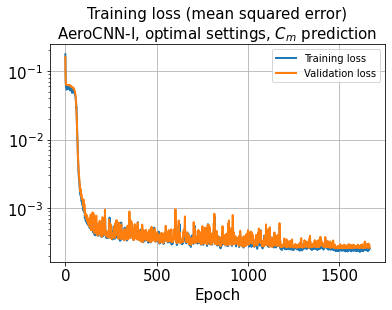

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

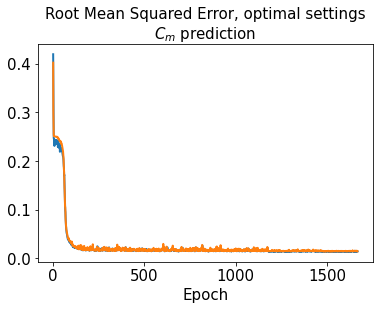

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

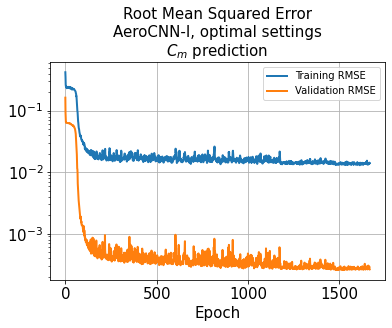

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 3ms/step - loss: 2.4124e-04 - rmse: 0.0133


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 4ms/step - loss: 2.6189e-04 - rmse: 0.0140


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 5ms/step - loss: 3.4492e-04 - rmse: 0.0167


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.030600420279527966
1.1734316618371363


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.03194867411039603
1.228242337408446


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.038134241750129375
1.3687078110282518


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

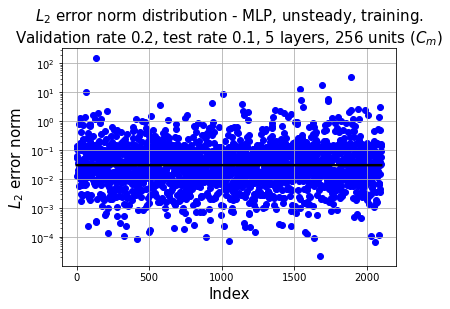

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

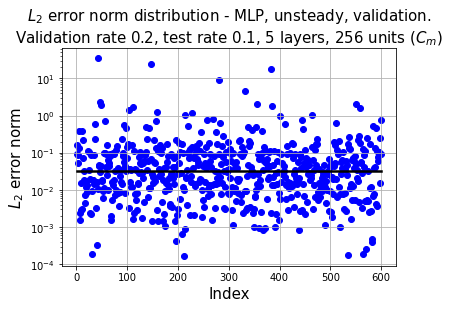

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

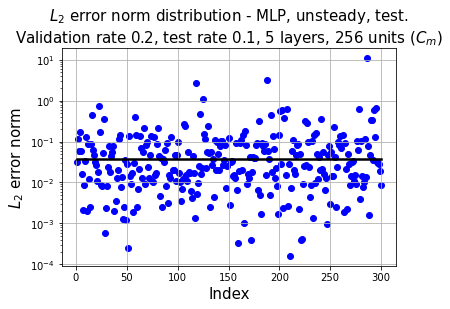

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.98268974], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.03171890417297435


In [88]:
cm[2000]

array([0.00682824])

In [89]:
cm[1000]

array([0.0014248])

In [67]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [84]:
len(predicted[index_train])

2100

In [83]:
len(predicted[index_val])

601

In [85]:
len(predicted[index_test])

301

In [74]:
x_time += 10

L2 error of Cm: 0.0316


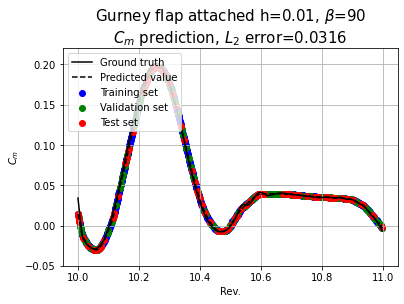

L2 error of Cm: 0.0414


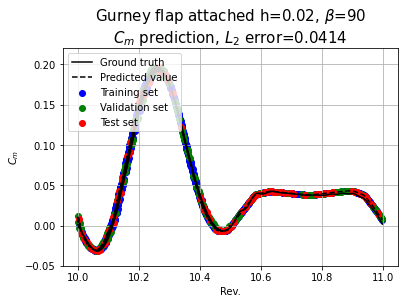

L2 error of Cm: 0.0165


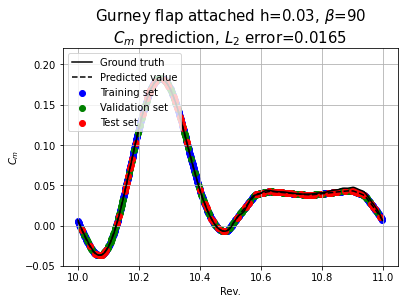

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0316


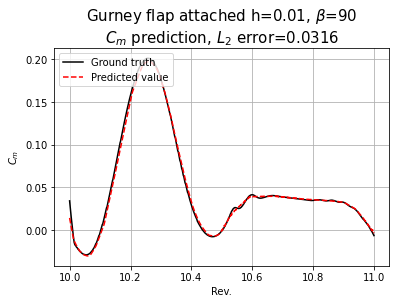

L2 error of Cm: 0.0414


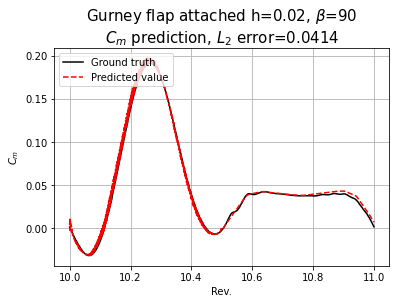

L2 error of Cm: 0.0165


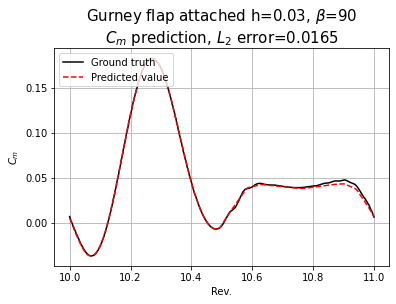

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0316


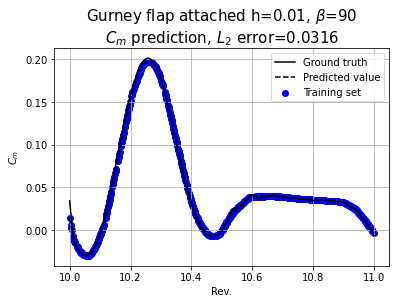

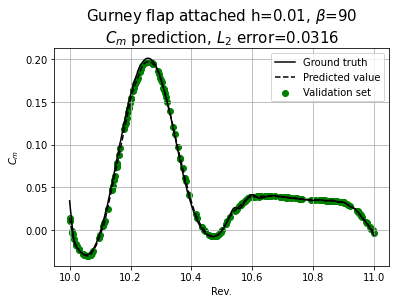

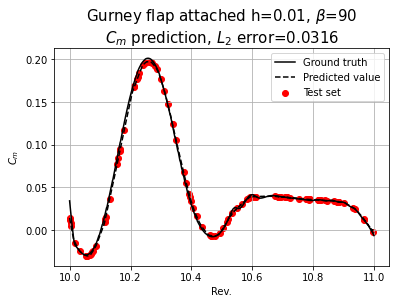

L2 error of Cm: 0.0414


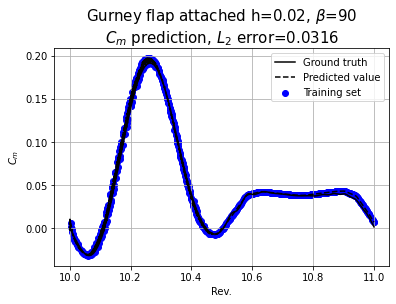

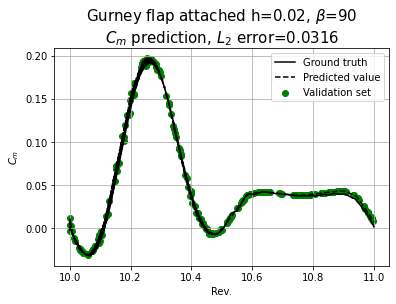

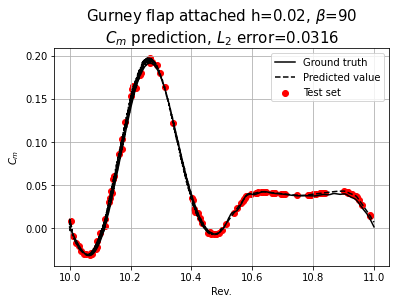

L2 error of Cm: 0.0165


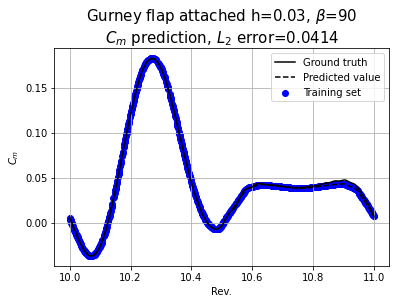

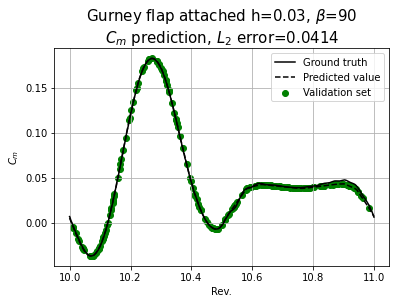

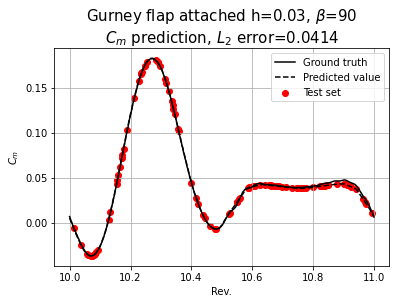

In [81]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

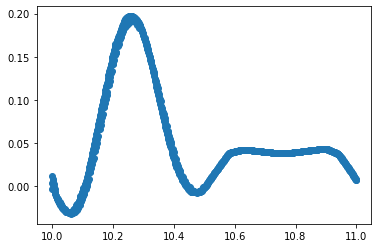

In [97]:
plt.scatter(t[:1000], denormalize(predicted[1000:2000]),  label='Predicted value')